# **Save this file as studentid1_studentid2_lab#.ipynb**
(Your student-id is the number shown on your student card.)

E.g. if you work with 3 people, the notebook should be named:
12301230_3434343_1238938934_lab1.ipynb.

**This will be parsed by a regexp, so please double check your filename.**

**Only one member of each group has to submit the file to canvas.**

Before you turn this problem in, please make sure everything runs correctly. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All). Note, that **you are not allowed to use Google Colab**.

**Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your names and email adresses below.**



In [1]:
NAME = ""
NAME2 = ""
NAME3 = ""
EMAIL = ""
EMAIL2 = ""
EMAIL3 = ""

# Lab 1: Linear Regression and Overfitting

### Machine Learning 1, September/October 2019

Notes on implementation:

* You should write your code and answers in this IPython Notebook: http://ipython.org/notebook.html. If you have problems, please contact your teaching assistant.
* Please write your answers right below the questions.
* Among the first lines of your notebook should be "%pylab inline". This imports all required modules, and your plots will appear inline.
* Refer to last week's lab notes, i.e. http://docs.scipy.org/doc/, if you are unsure about what function to use. There are different correct ways to implement each problem!
* For this lab, your regression solutions should be in closed form, i.e., should not perform iterative gradient-based optimization but find the exact optimum directly.
* use the provided test boxes to check if your answers are correct

In [2]:
%pylab inline
plt.rcParams["figure.figsize"] = [20,10]

Populating the interactive namespace from numpy and matplotlib


In [3]:
# This cell makes sure that you have all the necessary libraries installed

import sys
import platform
from importlib.util import find_spec, module_from_spec

def check_newer_version(version_inst, version_nec):
    version_inst_split = version_inst.split('.')
    version_nec_split = version_nec.split('.')
    for i in range(min(len(version_inst_split), len(version_nec_split))):
        if int(version_nec_split[i]) > int(version_inst_split[i]):
            return False
        elif int(version_nec_split[i]) < int(version_inst_split[i]):
            return True
    return True


module_list = [('jupyter', '1.0.0'), 
               ('matplotlib', '2.0.2'), 
               ('numpy', '1.13.1'), 
               ('python', '3.6.2'), 
               ('sklearn', '0.19.0'), 
               ('scipy', '0.19.1'), 
               ('nb_conda', '2.2.1')]

packages_correct = True
packages_errors = []

for module_name, version in module_list:
    if module_name == 'scikit-learn':
        module_name = 'sklearn'
    if 'python' in module_name:
        python_version = platform.python_version()
        if not check_newer_version(python_version, version):
            packages_correct = False
            error = f'Update {module_name} to version {version}. Current version is {python_version}.'
            packages_errors.append(error) 
            print(error)
    else:
        spec = find_spec(module_name)
        if spec is None:
            packages_correct = False
            error = f'Install {module_name} with version {version} or newer, it is required for this assignment!'
            packages_errors.append(error) 
            print(error)
        else:
            x = __import__(module_name)
            if hasattr(x, '__version__') and not check_newer_version(x.__version__, version):
                packages_correct = False
                error = f'Update {module_name} to version {version}. Current version is {x.__version__}.'
                packages_errors.append(error) 
                print(error)

try:
    from google.colab import drive
    packages_correct = False
    error = """Please, don't use google colab!
It will make it much more complicated for us to check your homework as it merges all the cells into one."""
    packages_errors.append(error) 
    print(error)
except:
    pass

packages_errors = '\n'.join(packages_errors)

$\newcommand{\bPhi}{\mathbf{\Phi}}$
$\newcommand{\bx}{\mathbf{x}}$
$\newcommand{\bw}{\mathbf{w}}$
$\newcommand{\bt}{\mathbf{t}}$
$\newcommand{\by}{\mathbf{y}}$
$\newcommand{\bm}{\mathbf{m}}$
$\newcommand{\bS}{\mathbf{S}}$
$\newcommand{\bI}{\mathbf{I}}$

## Part 1: Polynomial Regression

### 1.1. Generate periodic data (5 points)
Write a method `gen_sine(N)` that generates toy data like in fig 1.2 of Bishop's book. The method should have a parameter $N$, and should return $N$-dimensional vectors $\bx$ and $\bt$, where $\bx$ contains evenly spaced values from 0 to (including) 2$\pi$, and the elements $t_i$ of $\bt$ are distributed according to:

$$t_i \sim \mathcal{N}(\mu_i, \sigma^2)$$

where $x_i$ is the $i$-th elements of $\bf{x}$, the mean $\mu_i = \sin(x_i)$ and the standard deviation $\sigma = 0.25$. You can make use of `np.random.normal()` (Hint: Double check its input parameters).


In [4]:
def gen_sine(n):
    # YOUR CODE HERE
    x = np.linspace(0, 2*np.pi, n)
    t= np.sin(x)+[np.random.normal(0, 0.25) for i in range(n)]
    return x, t


In [5]:
### Test your function
np.random.seed(42)
N = 10
x, t = gen_sine(N)

assert x.shape == (N,), "the shape of x is incorrect"
assert t.shape == (N,), "the shape of t is incorrect"



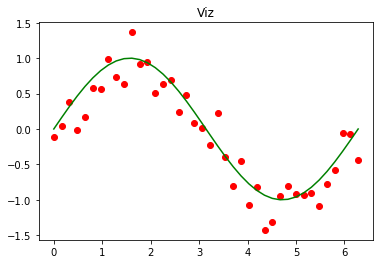

In [6]:
### Visualize the plot
x, t = gen_sine(40)
plt.plot(x, t, 'ro')
plt.plot(x, np.sin(x),'g')
plt.title('Viz')
plt.show()

### 1.2 Polynomial regression (10 points)

Write a method `fit_polynomial(x, t, M)` that finds the maximum-likelihood solution of an _unregularized_ $M$-th order polynomial for some dataset `x`. The error function to minimize w.r.t. $\bw$ is:

$E(\bw) = \frac{1}{2} (\bPhi\bw - \bt)^T(\bPhi\bw - \bt)$

where $\bPhi$ is the _feature matrix_ (or _design matrix_) as explained in Bishop's book at section 3.1.1, $\bt$ is the vector of target values. Your method should return a vector $\bw$ with the maximum-likelihood parameter estimates, as well as the _feature matrix_ $\bPhi$.

In [7]:
def designmatrix(x, M): # it is highly recommended to write a helper function that computes Phi
    # design matrix will shape N x M, where N is number of samples in x
    N = len(x)
    features = []
    for j in range(N):
        _row = []
        for i in range(M+1):
            # pow is the poly base here, could be other functions also
            _row.append(pow(x[j], i))
        features.append(_row)
    return np.array(features)

def fit_polynomial(x, t, M):
    Phi =designmatrix(x, M)
    # here we use numpy builtin to calculate the peudo inverse
    w_ml = np.linalg.pinv(Phi).dot(t)
    return w_ml, Phi


In [8]:
### Test your function
N = 10
x = np.linspace(-1, 1, N)
t = 0.3*np.square(x) + 2.5
m = 2
w, Phi = fit_polynomial(x,t,m)

assert w.shape == (m+1,), "The shape of w is incorrect"
assert Phi.shape == (N, m+1), "The shape of Phi is incorrect"



In [9]:
### Test your function
N = 10
x = np.linspace(-1, 1, N)
t = 0.3*np.square(x) + 2.5
m = 2
w, Phi = fit_polynomial(x,t,m)
print(w)
print(Phi)

assert w.shape == (m+1,), "The shape of w is incorrect"
assert Phi.shape == (N, m+1), "The shape of Phi is incorrect"

[2.5000000e+00 8.8817842e-16 3.0000000e-01]
[[ 1.         -1.          1.        ]
 [ 1.         -0.77777778  0.60493827]
 [ 1.         -0.55555556  0.30864198]
 [ 1.         -0.33333333  0.11111111]
 [ 1.         -0.11111111  0.01234568]
 [ 1.          0.11111111  0.01234568]
 [ 1.          0.33333333  0.11111111]
 [ 1.          0.55555556  0.30864198]
 [ 1.          0.77777778  0.60493827]
 [ 1.          1.          1.        ]]


### 1.3 Plot (5 points)
Sample a dataset with $N=10$, and fit four polynomials with $M \in (0, 2, 4, 8)$.
For each value of $M$, plot the prediction function, along with the data and the original sine function. The resulting figure should look similar to fig 1.4 of the Bishop's book. Note that you can use matplotlib's `plt.pyplot(.)` functionality for creating grids of figures.

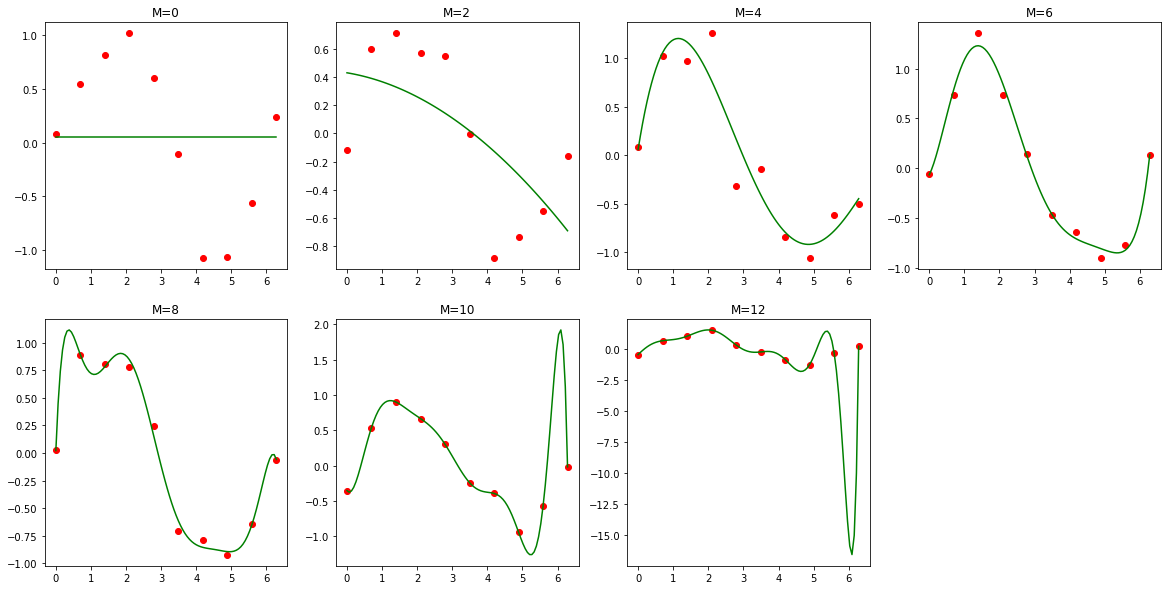

In [10]:
M = [0,2,4,6,8,10,12]
N = 10
plt.rcParams["figure.figsize"] = [20,10]
for i in range(len(M)):
    plt.subplot(2,4,i+1)
    x, t = gen_sine(N)
    plt.plot(x, t, 'ro')
    w, Phi = fit_polynomial(x,t,M[i])

    pred_x = np.linspace(0, 2*np.pi, 100)
    detailed_Phi = designmatrix(pred_x, M[i])
    pred = detailed_Phi.dot(w)
    plt.plot(pred_x, pred,'g')
    plt.title("M={}".format(M[i]))

plt.show()

### 1.4 Regularized linear regression (15 points)

a) (10 points) Write a method `fit_polynomial_reg(x, t, M, lamb)` that fits a _regularized_ $M$-th order polynomial to the periodic data, as discussed in the lectures, where `lamb` is the regularization term _lambda_. (Note that 'lambda' cannot be used as a variable name in Python since it has a special meaning). The error function to minimize w.r.t. $\bw$:

$E(\bw) = \frac{1}{2} (\bPhi\bw - \bt)^T(\bPhi\bw - \bt) + \frac{\lambda}{2} \mathbf{w}^T \mathbf{w}$

For background, see section 3.1.4 of Bishop's book.

The function should return $\bw$ and $\bPhi$.

In [11]:
def fit_polynomial_reg(x, t, m, lamb):
    Phi =designmatrix(x, m)
    # here we use numpy builtin to calculate the peudo inverse
    w_ml = np.linalg.inv(lamb*np.identity(m+1) + np.transpose(Phi).dot(Phi)).dot(np.transpose(Phi)).dot(t)
    return w_ml, Phi

In [12]:
### Test your function
N = 10
x = np.linspace(-1, 1, N)
t = 0.3*np.square(x) + 2.5
m = 2
lamb = 0.1
w, Phi = fit_polynomial_reg(x,t,m, lamb)

assert w.shape == (m+1,), "The shape of w is incorrect"
assert Phi.shape == (N, m+1), "The shape of w is incorrect" 



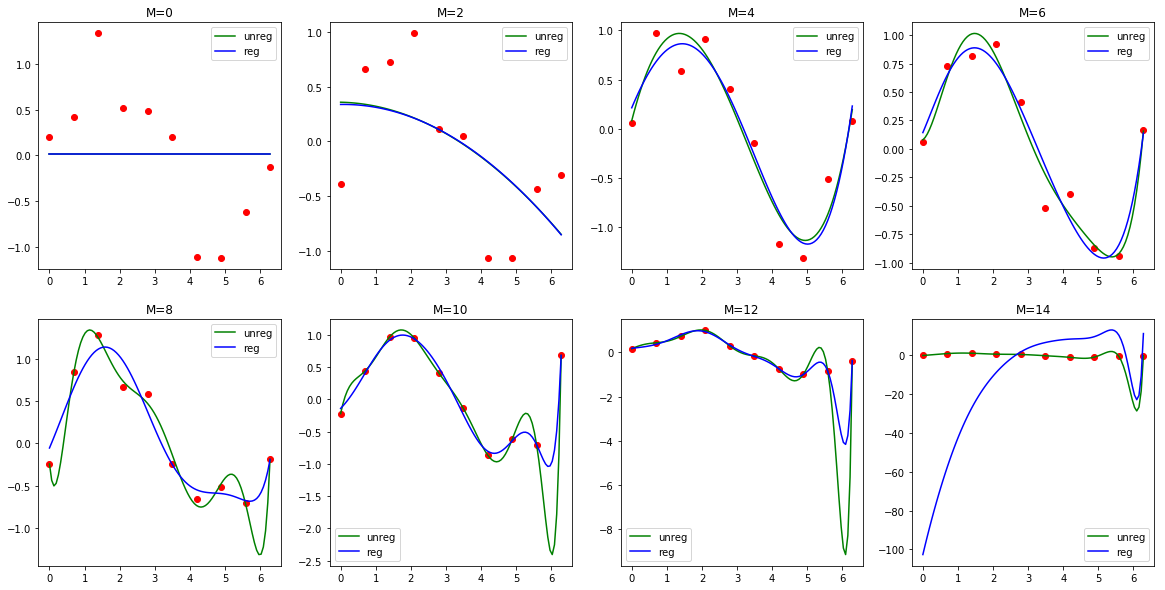

In [13]:
M = [0,2,4,6,8,10,12,14]
N = 10
plt.rcParams["figure.figsize"] = [20,10]
for i in range(len(M)):
    plt.subplot(2,4,i+1)
    x, t = gen_sine(N)
    plt.plot(x, t, 'ro')
    w, Phi = fit_polynomial(x,t,M[i])
    w_reg, Phi_reg = fit_polynomial_reg(x,t,M[i], 0.1)
    # print("weights (M={}):".format(M[i]), w)

    pred_x = np.linspace(0, 2*np.pi, 100)
    detailed_Phi = designmatrix(pred_x, M[i])
    pred = detailed_Phi.dot(w)
    pred_reg = detailed_Phi.dot(w_reg)
    plt.plot(pred_x, pred, "g", label="unreg")
    plt.plot(pred_x, pred_reg, "b", label="reg")
    plt.legend(loc='best')
    plt.title("M={}".format(M[i]))

plt.show()

b) (5 points) What changes do you notice in $\bw$ and $\bPhi$ after introducing the regularization term? Why is this happening? 

(Write no more than 5 lines. For example, you can consider the simple test case with $t = 0.3*x^2 + 2.5$)

Ans:

After introducing regularization term, the distribution of $\bw$ is more even.
e.g. when $\lambda = 0.1$, we have

$t = 0.35*x^2 + 2.45, |w_1 - w_2| = 2.1 $

$t = 0.3*x^2 + 2.5, |w_1 - w_2| = 2.2 $






### 1.5 Model selection by cross-validation (15 points)
Use cross-validation to find a good choice of $M$ and $\lambda$, given a dataset of $N=10$ datapoints generated with `gen_sine(10)`. You should write a function that tries (loops over) a reasonable range of choices of $M$ and $\lambda$, and returns the choice with the best cross-validation error. In this case you use $K=5$ folds.

You can let $M \in (0, 1, ..., 10)$, and let $\lambda \in (e^{-10}, e^{-9}, ..., e^{0})$.

a) (5 points) First of all, write a method `pred_error(x_train, x_valid, t_train, t_valid, M, lamb)` that compares the prediction of your method `fit_polynomial_reg` for a given set of parameters $M$ and $\lambda$ to `t_valid`. It should return the prediction error for a single fold.

In [14]:
def pred_error(x_train, x_valid, t_train, t_valid, M, reg):
    # with x_train, t_train, M and reg, we can have w
    w, train_Phi = fit_polynomial_reg(x_train,t_train,M, reg)
    # then we can calculate the feature matrix for x_valid
    vaid_Phi = designmatrix(x_valid, M)
    valid_pred_t = vaid_Phi.dot(w)
    # we use sum_of_square_error / 2, as in the bishop book
    pred_err = np.sum((valid_pred_t - t_valid)**2)/2
    print("pred error = {}".format(pred_err))
    return pred_err

In [15]:
### Test your function
N = 10
x = np.linspace(-1, 1, N)
t = 0.3*np.square(x) + 2.5
M = 2
reg = 0.1
pred_err = pred_error(x[:-2], x[-2:], t[:-2], t[-2:], M, reg)

assert pred_err < 0.001, "pred_err is too big"



pred error = 0.000356408196342407


b) (10 points) Now write a method find_best_m_and_lamb(x, t) that finds the best values for $M$ and $\lambda$. The method should return the best $M$ and $\lambda$. To get you started, here is a method you can use to generate indices of cross-validation folds.

In [16]:
def kfold_indices(N, k):
    all_indices = np.arange(N,dtype=int)
    np.random.shuffle(all_indices)
    idx = [int(i) for i in np.floor(np.linspace(0,N,k+1))]
    train_folds = []
    valid_folds = []
    for fold in range(k):
        valid_indices = all_indices[idx[fold]:idx[fold+1]]
        valid_folds.append(valid_indices)
        train_folds.append(np.setdiff1d(all_indices, valid_indices))
    return train_folds, valid_folds


In [17]:
kfold_indices(10,5)

([array([0, 1, 2, 4, 6, 7, 8, 9]),
  array([0, 1, 2, 3, 5, 6, 7, 8]),
  array([0, 1, 3, 4, 5, 7, 8, 9]),
  array([0, 1, 2, 3, 4, 5, 6, 9]),
  array([2, 3, 4, 5, 6, 7, 8, 9])],
 [array([3, 5]), array([4, 9]), array([2, 6]), array([8, 7]), array([0, 1])])

In [18]:
M_space = [i for i in range(11)]
lamb_space = [np.exp(i) for i in range(-10,1)]
N = 10
k = 5

In [19]:
def find_best_m_and_lamb(x, t):
    # YOUR CODE HERE
    train_folds, valid_folds = kfold_indices(N,k)
    best_error= float("inf")
    M_best = None
    lamb_best = None
    for m in M_space:
        for lamb in lamb_space:
            print("m={}, lambda={}".format(m, lamb))
            error_all_folds = []
            # for single set og lamb, m, we calculate the mean pred error for k folds
            for k_count in range(k):
                print("fold-{}".format(k_count+1))
                train_fold_indices = train_folds[k_count]
                valid_fold_indices = valid_folds[k_count]
                x_train_fold = [x[i] for i in train_fold_indices]
                x_valid_fold = [x[i] for i in valid_fold_indices]
                t_train_fold = [t[i] for i in train_fold_indices]
                t_valid_fold = [t[i] for i in valid_fold_indices]
                error_single_fold = pred_error(x_train_fold, x_valid_fold, t_train_fold, t_valid_fold, m, lamb)
                error_all_folds.append(error_single_fold)
            
            # now we have the cross-validation error for a set of m and lamb
            cross_error = np.mean(error_all_folds)
            print("cross validation error = {}".format(cross_error))
            print("--------------")
            
            if cross_error < best_error:
                best_error = cross_error
                M_best = m
                lamb_best=lamb 
    
    return M_best, lamb_best


In [20]:
x1, t1 = gen_sine(10)
# find the best model
M_best1, lamb_best1 = find_best_m_and_lamb(x1, t1)
M_best1, lamb_best1

m=0, lambda=4.5399929762484854e-05
fold-1
pred error = 0.674736695878847
fold-2
pred error = 0.3276212706837468
fold-3
pred error = 0.11195419587650413
fold-4
pred error = 1.026901081114635
fold-5
pred error = 0.41753479027384255
cross validation error = 0.5117496067655152
--------------
m=0, lambda=0.00012340980408667956
fold-1
pred error = 0.6747366896830679
fold-2
pred error = 0.3276210415883424
fold-3
pred error = 0.11195299777850017
fold-4
pred error = 1.0268968774825018
fold-5
pred error = 0.41753496257287304
cross validation error = 0.511748513821057
--------------
m=0, lambda=0.00033546262790251185
fold-1
pred error = 0.6747366728418045
fold-2
pred error = 0.32762041888443216
fold-3
pred error = 0.11194974116328053
fold-4
pred error = 1.0268854513151002
fold-5
pred error = 0.4175354309134666
cross validation error = 0.5117455430236169
--------------
m=0, lambda=0.0009118819655545162
fold-1
pred error = 0.6747366270670181
fold-2
pred error = 0.3276187265097391
fold-3
pred error 

pred error = 0.05786424107198469
fold-3
pred error = 0.1369261172160266
fold-4
pred error = 0.20516364992773106
fold-5
pred error = 0.2351800507132668
cross validation error = 0.22730747315719563
--------------
m=5, lambda=0.01831563888873418
fold-1
pred error = 0.2877998091563808
fold-2
pred error = 0.05570445315311946
fold-3
pred error = 0.10107569768529795
fold-4
pred error = 0.19867057290093246
fold-5
pred error = 0.20740801498995068
cross validation error = 0.17013170957713625
--------------
m=5, lambda=0.049787068367863944
fold-1
pred error = 0.08101626056417716
fold-2
pred error = 0.05330376971210414
fold-3
pred error = 0.08184850120171014
fold-4
pred error = 0.20553622378119119
fold-5
pred error = 0.1648056159111147
cross validation error = 0.11730207423405944
--------------
m=5, lambda=0.1353352832366127
fold-1
pred error = 0.06392418464345584
fold-2
pred error = 0.054393894883624616
fold-3
pred error = 0.07172658770474118
fold-4
pred error = 0.23019572304804647
fold-5
pred er

(3, 0.1353352832366127)

In [21]:
### This is not an empty cell (You don't need to care about it).

### 1.6 Why grid search? (5 points)

Grid search is an commonly-used technique to tune hyper-parameters in a model.
Considering the case described in the previous step of this assignment, running a grid search over the possible parameter values (10 possible values for both $M$ and $\lambda$), results in two nested loops exploring $10 \times 10 = 100$ different configurations for the model. 

a) (3 points) Why do we want to optimize by changing the two hyperparameters at the same time, and not in a sequential way? We could initialise all parameters randomly, fix one parameter at a time and iterate over the other, resulting in only $10 + 10 = 20$ experiments!

**My answer: It is obvious that if we do in a sequential way, we are not considering all possible combinations of pamameters, thus could lead to missing the best solution.**

For more complex models, the number of combinations easily explodes with the number of parameters. For example, with 5 parameters we would run $10 \times 10 \times 10 \times 10 \times 10 = 100,000$ experiments.

b) (2 points) Try to think or find in literature one alternative to grid search to tune hyper-parameters more efficiently. Explain very briefly (2-3 lines max) how this method avoids the combinatorial explosion we have see in grid search.

YOUR ANSWER HERE

### 1.7 Plot best cross-validated fit (5 points)

For some dataset with $N = 10$, plot the model with the optimal $M$ and $\lambda$ according to the cross-validation error, using the method you just wrote. In addition, the plot should show the dataset itself and the function that we try to approximate. Let the plot make clear which $M$ and $\lambda$ were found.

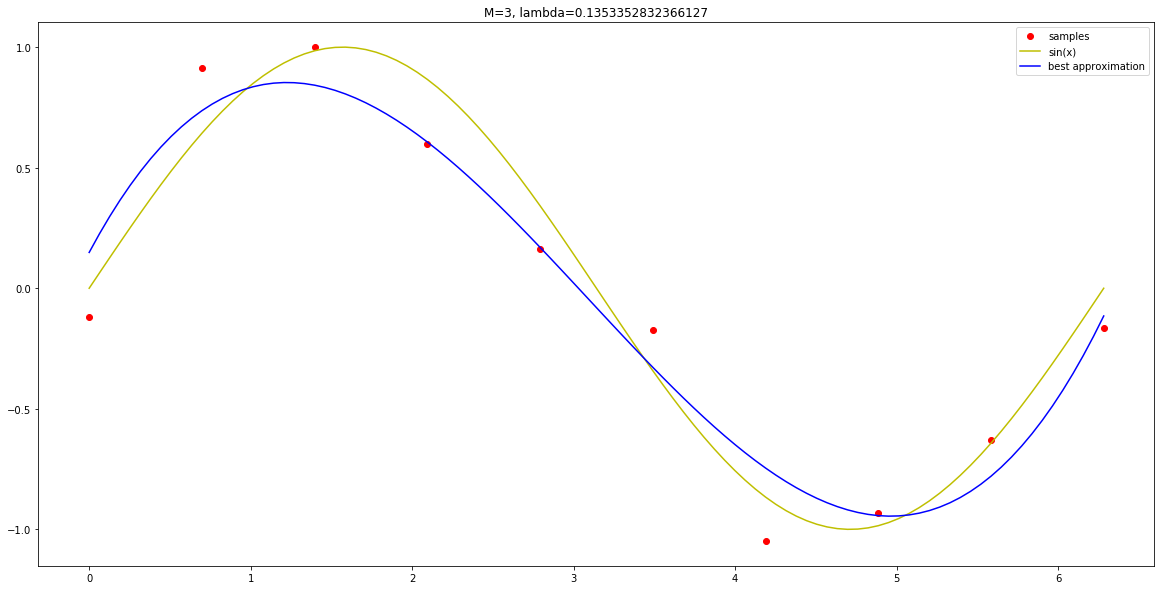

In [22]:
M = [0,2,4,6,8,10,12,14]
N = 10
plt.rcParams["figure.figsize"] = [20,10]

x, t = gen_sine(N)
plt.plot(x, t, 'ro', label="samples")
w_reg, Phi_reg = fit_polynomial_reg(x,t,M_best1, lamb_best1)
# print("weights (M={}):".format(M[i]), w)


pred_x = np.linspace(0, 2*np.pi, 100)
plt.plot(pred_x, np.sin(pred_x), "y", label="sin(x)")

detailed_Phi = designmatrix(pred_x, M_best1)
pred_reg = detailed_Phi.dot(w_reg)
plt.plot(pred_x, pred_reg, "b", label="best approximation")
plt.legend(loc='best')
plt.title("M={}, lambda={}".format(M_best1, lamb_best1))


plt.show()

## Part 2: Bayesian Linear (Polynomial) Regression

### 2.1 Sine 2 (5 points)

Write a function `gen_sine2(N)` that behaves identically to `gen_sine(N)` except that the generated values $x_i$ are not linearly spaced, but drawn from a uniform distribution between $0$ and $2 \pi$.

In [23]:
# from scipy.stats import truncnorm

# def get_truncated_normal(mean=5, std=1, low=0, upp=10, size=1000):
#     # check scipy documentation for this
#     trunc_norm = truncnorm((low - mean) / std, (upp - mean) / std, loc=mean, scale=std)
#     return trunc_norm.rvs(size)

def gen_sine2(n):
    x = np.random.uniform(0, 2 * np.pi, n)
    sigma = 0.25
    t= np.sin(x)+[np.random.normal(0, sigma) for i in range(n)]
    return x, t

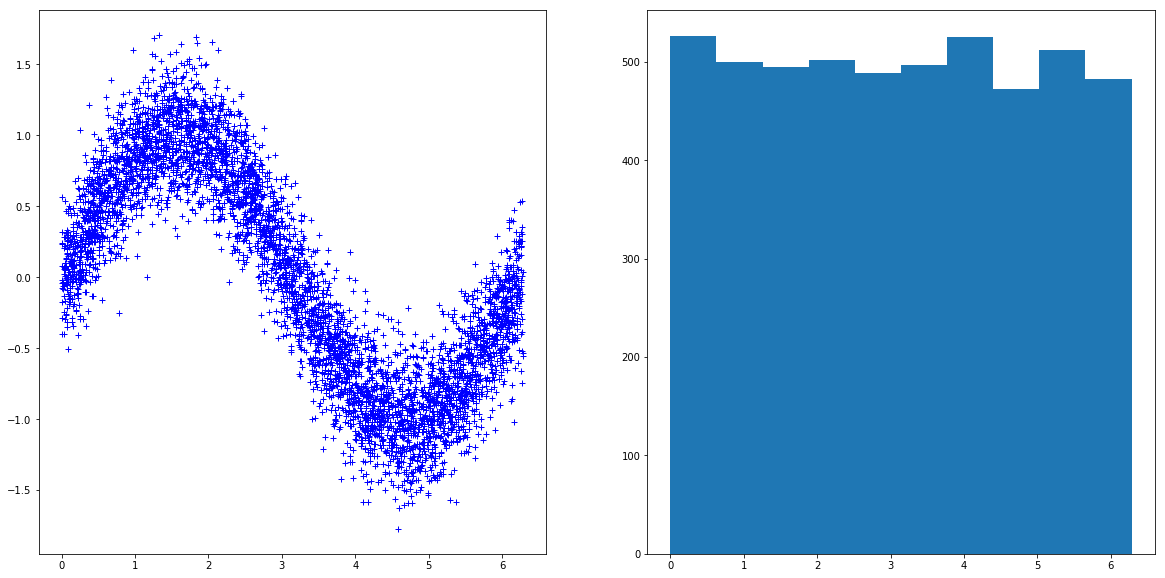

In [24]:
### Visualize the plot
_SIZE = 5000
x, t = gen_sine2(_SIZE)
plt.subplot(121)
plt.plot(x, t, 'b+')
# plt.plot(x, np.sin(x),'g')
plt.subplot(122)
plt.hist(x)
plt.show()

As we can see in the Figure, $x$ is distributed according to Gaussian, thus we see more points around the mean.

In [25]:
### Test your function
np.random.seed(42)
N = 10
x, t = gen_sine2(N)

assert x.shape == (N,), "the shape of x is incorrect"
assert t.shape == (N,), "the shape of t is incorrect"



### 2.2 Compute Posterior (15 points)

You're going to implement a Bayesian linear regression model, and fit it to the periodic data. Your regression model has a zero-mean isotropic Gaussian prior over the parameters, governed by a single (scalar) precision parameter $\alpha$, i.e.:

$$p(\bw \;|\; \alpha) = \mathcal{N}(\bw \;|\; 0, \alpha^{-1} \bI)$$

The covariance and mean of the posterior are given by:

$$\bS_N= \left( \alpha \bI + \beta \bPhi^T \bPhi \right)^{-1} $$
$$\bm_N = \beta\; \bS_N \bPhi^T \bt$$

where $\alpha$ is the precision of the predictive distribution, and $\beta$ is the noise precision. 
See MLPR chapter 3.3 for background.

Write a method `fit_polynomial_bayes(x, t, M, alpha, beta)` that returns the mean $\bm_N$ and covariance $\bS_N$ of the posterior for a $M$-th order polynomial. In addition it should return the design matrix $\bPhi$. The arguments `x`, `t` and `M` have the same meaning as in question 1.2.

In [26]:
def fit_polynomial_bayes(x, t, M, alpha, beta):
    Phi = designmatrix(x, M)
    S = linalg.inv(alpha * np.eye(Phi.shape[1]) + beta * np.dot(Phi.T, Phi))
    m = beta * S.dot(Phi.T).dot(t)    
    return m, S, Phi


In [27]:
### Test your function
N = 10
x = np.linspace(-1, 1, N)
t = 0.3*np.square(x) + 2.5
M = 2
alpha = 0.6
beta = 16
m, S, Phi = fit_polynomial_bayes(x, t, M, alpha, beta)

assert m.shape == (M+1,), "the shape of m is incorrect" 
assert S.shape == (M+1, M+1), "the shape of S is incorrect"
assert Phi.shape == (N, M+1), "the shape of Phi is incorrect"



### 2.3 Prediction (10 points)

The predictive distribution of Bayesian linear regression is:

$$ p(t \;|\; \bx, \bt, \alpha, \beta) = \mathcal{N}(t \;|\; \bm_N^T \phi(\bx), \sigma_N^2(\bx))$$

$$ \sigma_N^2 = \frac{1}{\beta} + \phi(\bx)^T \bS_N \phi(\bx) $$

where $\phi(\bx)$ are the computed features for a new datapoint $\bx$, and $t$ is the predicted variable for datapoint $\bx$. 

Write a function that `predict_polynomial_bayes(x, m, S, beta)` that returns the predictive mean, variance and design matrix $\bPhi$ given a new datapoint `x`, posterior mean `m`, posterior variance `S` and a choice of model variance `beta`.

In [28]:
def predict_polynomial_bayes(x, m, S, beta):
    # each datapoint in x has its own mean and sigma
    count_datapoints = len(x) # the row count is x is multi dimensional
    M = len(m) -1
    Phi = designmatrix(x, M)
    print(Phi.shape)
    mean = []
    sigma = []
    for i in range(count_datapoints):
        _mean = m.dot(Phi[i].T)
        mean.append(_mean)
        _sigma =  1.0 / beta + Phi[i].dot(S).dot(Phi[i].T)
        sigma.append(_sigma)
    return np.array(mean), np.array(sigma), Phi


In [29]:
### Test your function
np.random.seed(42)
N = 10
x = np.linspace(-1, 1, N)
m = np.random.rand(3)
S = np.random.rand(3, 3)
beta = 16
mean, sigma, Phi = predict_polynomial_bayes(x, m, S, beta)

assert mean.shape == (N,), "the shape of mean is incorrect"
assert sigma.shape == (N,), "the shape of sigma is incorrect"
assert Phi.shape == (N, m.shape[0]), "the shape of Phi is incorrect"



(10, 3)


### 2.4 Plot predictive distribution (10 points)

a) (5 points) Generate 10 datapoints with `gen_sine2(10)`. Compute the posterior mean and covariance for a Bayesian polynomial regression model with $M=4$, $\alpha=\frac{2}{5}$ and $\beta=\frac{1}{0.25^2}$.
Plot the Bayesian predictive distribution, where you plot (for $x$ between 0 and $2 \pi$) $t$'s predictive mean and the predictive standard deviation using `plt.fill_between(..., alpha=0.1)` (the alpha argument induces transparency).

Include the datapoints in your plot.


(100, 5)
(1000, 5)


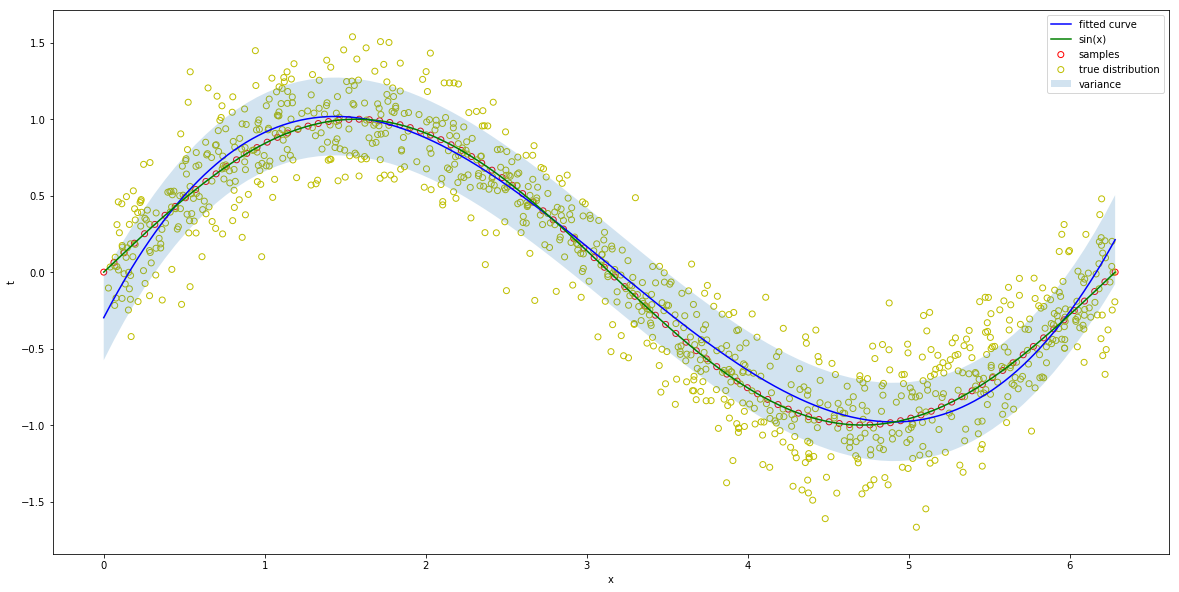

In [30]:
N = 100
M = 4
alpha = 2.0 / 5
beta = 1 / 0.25 ** 2
x, t = gen_sine2(N)
m, S, Phi_train = fit_polynomial_bayes(x, t, M, alpha, beta)

x_pred = np.linspace(0, 2*np.pi, N)
x_fine = np.linspace(0, 2*np.pi, 1000)
x_detailed, t_detailed = gen_sine2(1000)


mean, sigma, Phi_pred = predict_polynomial_bayes(x_pred, m, S, beta)
mean_fine, _, _ = predict_polynomial_bayes(x_fine, m, S, beta)

plt.scatter(x_pred, np.sin(x_pred), facecolors='none', edgecolors='r', label="samples")
plt.plot(x_fine, mean_fine, "b", label="fitted curve")

plt.scatter(x_detailed, t_detailed, facecolors='none', edgecolors='y', label="true distribution")

### plot sin(x)
sinx_x = np.linspace(0, 2*np.pi, 1000)
sinx_y = sin(sinx_x)
plt.plot(sinx_x, sinx_y, "g", label="sin(x)")

### fill in the prediction variance
plt.fill_between(x_pred, 
                 mean + np.sqrt(sigma),
                 mean - np.sqrt(sigma),
                 alpha=0.2,
                 label='variance'
                )
plt.legend()
plt.xlabel('x')
plt.ylabel('t')
plt.show()

b) (5 points) For a second plot, draw 100 samples from the parameters' posterior distribution. Each of these samples is a certain choice of parameters for 4-th order polynomial regression. 
Display each of these 100 polynomials.


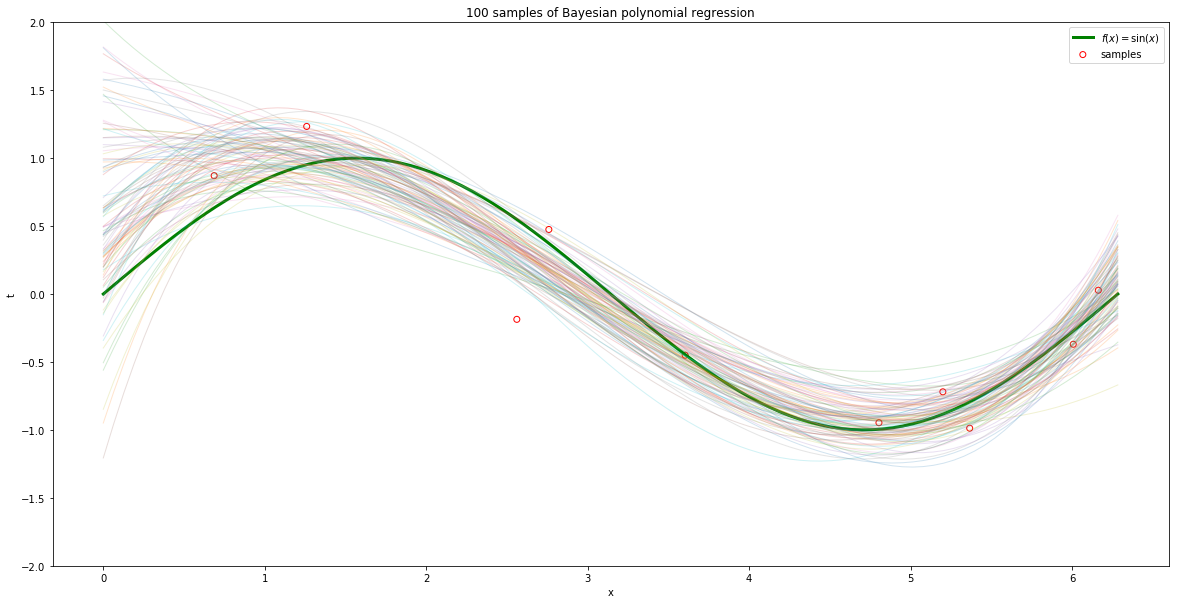

In [31]:
N = 10
M = 4
alpha = 2.0 / 5
beta = 1 / 0.25 ** 2

x, t = gen_sine2(N)
m, S, _ = fit_polynomial_bayes(x, t, M, alpha, beta)

x_detailed = np.linspace(0, 2 * np.pi, 100)
Phi_detailed = designmatrix(x_detailed, M)

plt.scatter(x, t, facecolors='none', edgecolors='r', label='samples')
plt.plot(x_detailed, np.sin(x_detailed), color='green', linewidth=3, label=r'$f(x)=\sin(x)$')

COUNT_BAYES = 100
for i in np.arange(COUNT_BAYES):
    # we draw a random w from its distribution defined by mean M of shape (M+1), and S of shape (M+1)x(M+1)
    w = np.random.multivariate_normal(m, S)
    plt.plot(x_detailed, Phi_detailed.dot(w), linewidth=1, alpha=0.2)

plt.ylim([-1 * 2, 1 * 2])   
plt.xlabel('x')
plt.ylabel('t')
plt.title('{} samples of Bayesian polynomial regression'.format(COUNT_BAYES))
plt.legend(loc='best')
plt.show()

### 2.5 Additional questions (10 points)

a) (5 points) Why is $\beta=16$ the best choice of $\beta$ in section 2.4?



$\beta=16 = \frac{1}{0.25^{2}} \longrightarrow \sigma=0.25$

This is the same as the standard deviation used in $gen\_sine2$. Therefore, $\beta=16$ makes the predictive distribution $p(\mathbf{t}|\mathbf{X}, \mathbf{w}, \beta) = \mathcal{N}(\mathbf{t}|\mathbf{\Phi w}, \beta^{-1} \mathbf{I})$ shares the same variance with the training data(samples).

b) (5 points) What problems do we face when it comes to choosing basis functions in linear models?

When it comes to choosing basis functions, there are multiple factors to consider:

 - Basis function types. In the example of polynomial regression, we can use $\Phi_j(x) = x^j$. There are also alternative basis functions, such as gaussian functions, sigmoidal functions, or Fourier basis. There is no gold standard for choosing the right basis functions. In practice, prior knowledge should be utilized to choose the best basis functions.
 - Model complexity. In the exmaple of polynomial basis function, we have seen that when the model complexity is high (larger order of M), overfitting could happen, which leads to bad generazition; when the model complexity is low (smaller order of M), underfitting could happen.
 - Computational expenses. One should also consider how computational intensive the model is. For example, if samples in trainings data are already very high dimensional, one should carefully choose the model complexity to be not so high, thus balancing out the already high dimensional input data.